# Using the Stark shift module

This tutorial will show how to use the Stark shift module to determine the deviation in $g$-factor arising from an applied electric field in the y-direction, where the plane of a device would be in the xz-plane.

In this tutorial, we will be defining the potential and the electric field that the dot(s) reside in analytically and therefore the xy-confining potential and the z-direction electric field will be decoupled. However, in practice with NextNano potentials, these two values will not be decoupled. The goal is to make this tutorial with NextNano potentials in due time.

Additionally, a wavefunction approximating the ground state wavefunction in each dot must be provided. This fixed wavefunction is then used in a varying electric field to calculate the $g$-factor deviation. This is an approximation since the ground state wavefunction will be slightly perturbed when gate voltages are changed. In the future, we hope to implement a many-body electron wavefunction which would allow us to bypass this step and give us a more accurate value for the $g$-factor for each electron.

In order for the file to not be too large, the output of the cells has been cleared so you will need to run the cells on your local machine to see the output.

## 1. Add the current location to path
In order for this tutorial to work, you will need to run this from the tutorials folder.

In [7]:
import os
from pathlib import Path
path = Path(os.getcwd())

# update base working directory to Tutorials
if path.stem != 'Tutorials':
    # print(path.parents[0])

    # move 2-directories up
    base_dir = path.parents[1]
    os.chdir(base_dir)
else:
    base_dir = path

## 2. Import the relevant modules

In [8]:
# From module
import qudipy.potential as pot
import qudipy.qutils as qt
import qudipy.starkshift as ss
from qudipy.utils import constants

# From external libraries
import numpy as np
import matplotlib.pyplot as plt

## 3. Define the potential

Here, we will use a bi-quadratic well as a potential for a double-dot system. The potentials are plotted below for us to confirm that it looks reasonable.


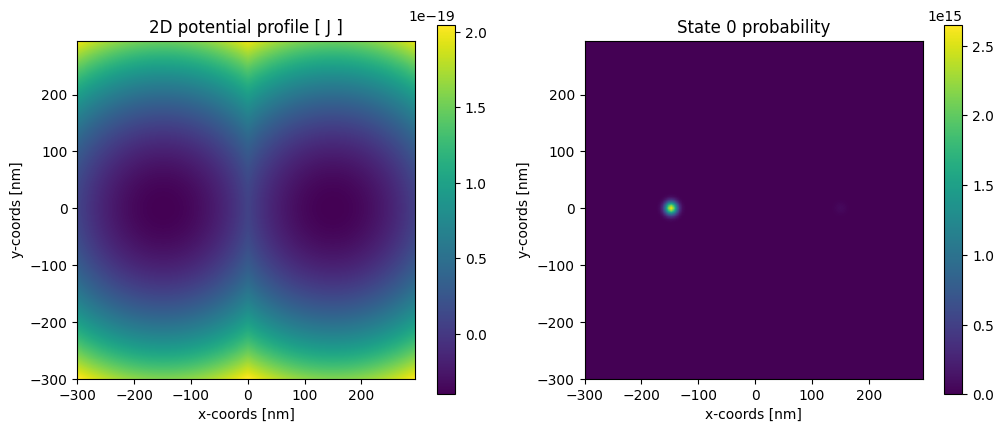

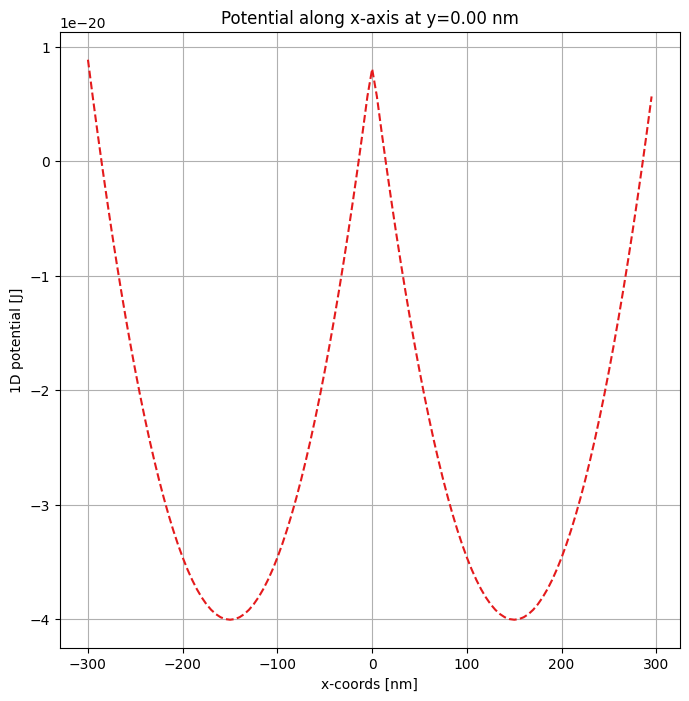

In [9]:
# Define constant for this material
mat_system = constants.select_material("Si/SiO2")
# Create control voltage names and variables the same way you would normally
ctrl_names = ['V1', 'V2']
V1 = [0.2, 0.22, 0.24, 0.26, 0.28]
V2 = [0.2, 0.22, 0.24, 0.26, 0.28]

ctrl_vals = [V1, V2]

# Specify the separation between dots (actual separation will be twice this number)
dot_sep = 150e-9

# Specify the x and y points you would like to have in a grid
x = np.arange(-2 * dot_sep, 2 * dot_sep, dot_sep/30)
y = np.arange(-2 * dot_sep, 2 * dot_sep, dot_sep/30)
# Create GridParams object
gparams = pot.GridParameters(x, y)

def create_potentials(cvals, gparams):
    # Get coordinates from mesh
    x_pot = gparams.x_mesh
    y_pot = gparams.y_mesh

    # Get voltages out from the control valriables
    v_1 = cvals[0]
    v_2 = cvals[1]

    # Convert (linear conversion) from voltages to chemical potentials
    # This is just a linear relationship with a dummy lever arm
    lever_arm_1 = 1
    mu_1 = v_1 * lever_arm_1 * constants.e
    lever_arm_2 = 1
    mu_2 = v_2 * lever_arm_2 * constants.e

    # Define frequency of harmonic oscillators
    omega_1 = 5e12
    omega_2 = 5e12

    # Define the potential
    well_1 = 1/2 * mat_system.me * omega_1**2 * (np.square(x_pot + dot_sep) + np.square(y_pot)) - mu_1
    well_2 = 1/2 * mat_system.me * omega_2**2 * (np.square(x_pot - dot_sep) + np.square(y_pot)) - mu_2
    potential = np.minimum(well_1, well_2)
    return potential

# Create the analytical potential using the variables defined above
analytic_potential = pot.load_data.analytical_potential(ctrl_vals, ctrl_names, create_potentials, x, y)
# Use the analytic potential to build an interpolator
pot_interp = pot.build_interpolator(analytic_potential, material="Si/SiO2")

# Plot potential to verify it makes sense
pot_interp.plot([0.25, 0.25], show_wf=True)
pot_interp.plot([0.25, 0.25], plot_type='1D', y_slice=0)

## 4. Define the electric field

We then do something similar for the electric field that we did for the potential. In this case, we define an analytical electric field that is the combination of two lines of charge above the location of the minima of the potential wells, where each control variable controls the charge denisty along each line. Although this isn't an entirely accurate model of two plunger gates over a double dot system, it allows us to see whether changing the voltage on one side of the double dot system changes the electron $g$-factor on the same side more than the other side as we would expect.

It is necessary that the electric field has the same control parameters as the potential landscape.

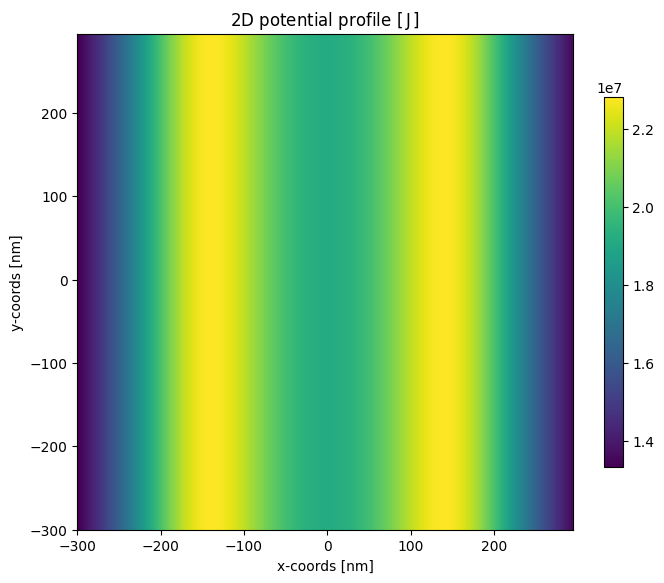

In [10]:
def e_field(cvals, gparams):
    # Get coordinates from mesh
    x_e = gparams.x_mesh
    y_e = gparams.y_mesh

    # Get voltages out from the control valriables
    v_1 = cvals[0]
    v_2 = cvals[1]

    # Convert (linear conversion) from voltages to chemical potentials
    # This is just a linear relationship
    # The lever arms are set arbitrarily so that the e-field is comprable to that in the literature
    lever_arm_1 = 3e-9
    lamb_1 = v_1 * lever_arm_1

    lever_arm_2 = 3e-9
    lamb_2 = v_2 * lever_arm_2
    
    # Define the electric field
    e_field = lamb_1 / (2 * np.pi * mat_system.eps * np.sqrt((x_e + dot_sep)**2 + (100e-9)**2)) + lamb_2 \
        / (2 * np.pi * mat_system.eps * np.sqrt((x_e - dot_sep)**2 + (100e-9)**2))
    return e_field

# Create the analytical electric using the variables defined above
analytic_e_field = pot.load_data.analytical_potential(ctrl_vals, ctrl_names, e_field, x, y)

# Use the analytic electric field to build an interpolator
e_interp = pot.build_interpolator(analytic_e_field, material="Si/SiO2")

# Plot potential to verify it makes sense
e_interp.plot([0.25, 0.25])

## 5. Calculate wavefunctions

Next, we must determine what the ground state wavefunction of each dot is. As stated in the introduction of this tutorial, the hope is that eventually this process can be done automatically, but for the time being this must be done manually.

In order to accomplish this, we simply detune the dot system so that the single electron Schrödinger equation solver gives us the correct ground state of each individual dot.

In [11]:
# Detune the system so the formation of the left dot is favored
new_pot = pot_interp([0.26, 0.25])
gparams.update_potential(new_pot)

# Solve Schrodinger equation and get the ground state wavefunction
e_ens, e_vecs = qt.solvers.solve_schrodinger_eq(mat_system, gparams, n_sols=1)
wavefunc_1 = e_vecs[:,:,0] # This is the ground state in the left dot

# Detune the system so the formation of the right dot is favored
new_pot = pot_interp([0.25, 0.26])
gparams.update_potential(new_pot) # This is the ground state in the right dot

# Solve Schrodinger equation and get the ground state wavefunction
e_ens, e_vecs = qt.solvers.solve_schrodinger_eq(mat_system, gparams, n_sols=1)
wavefunc_2 = e_vecs[:,:,0]

# Put these wavefunctions into a list to pass as a parameter for later
wavefuncs = [wavefunc_1, wavefunc_2]

## 6. Calculate Stark shift

Now that we have all of the preliminaries in place, we can calculate the Stark shift of each electron in the system.

We initialize a ```StarkShift``` object with the grid parameters and consts we used earlier on and then pass the electric field interpolator, the control parameter values to use, the control names, and the ground state wavefunctions we calculated. The output of the ```delta_g``` is a pandas DataFrame, with columns for each control variable and each the variation in $g$ for each electron in question.

In [12]:
# Now specify the potentials to interpolate around
v_vec = [[0.25, 0.25], [0.26, 0.25], [0.27, 0.25]]
v_vec = [[0.25, 0.25], [0.26, 0.25]]

# Calculate delta_g with gridparams, wavefunction and electric field and print result
stark_shift = ss.starkshift.StarkShift(gparams, 'Si/SiO2')
delta_g = stark_shift.delta_g(e_interp, v_vec, ctrl_names, wavefuncs=wavefuncs)
print(delta_g)

     V1    V2  delta_g_1  delta_g_2
0  0.25  0.25   0.001134   0.001134
1  0.26  0.25   0.001204   0.001156


We can see that as we increase ```V1``` (the applied voltage over the left dot), ```delta_g_1``` increases. This is the expected behavior. ```delta_g_2``` alo increases, but less than ```delta_g_1```. This makes sense since the second dot is farther away from the increasing voltage of the first plunger gate, but there is still cross coupling.